# Kongsberg KMALL compression testing.

These are some naive tests to see what is possible to better compress Kongsberg KMALL data files. 

In [1]:
import kmall
import numpy as np
import bz2
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import xarray as xr

In [2]:
importlib.reload(kmall)

<module 'kmall' from '/Users/vschmidt/gitsrc/kmall/kmall.py'>

In [2]:
K = kmall.kmall(filename="data/0007_20190513_154724_ASVBEN.kmall")
K.index_file()
r = K.check_ping_count()

                                   File  NpingsTotal  Pings Missed  MissingMRZRecords
 data/0007_20190513_154724_ASVBEN.kmall          238             2                  0


Headers have 20 bytes, and the first field indicates the number of bytes in the datagram. 

*Hypothesis*: Standard compression algorithms will do a better job when fields of like type and symantic meaning are grouped adjacent to each other, beause bit patterns are more likely to repeat in close proximity and repeating bit patterns are used to identify code-words for compression. 

*Test*: First compress the data file through some standard method and note the size of the resulting file. Then read all the data grams, note their order, re-order them grouping like datagrams into blocks, remove the headers from each, write all the headers in sequential order as one large block, the write all data grams of each type into single blocks, this should achieve the desired effect. Then compress the resulting file and compare to the original compressed file. 

To read the file, read all the headers by reading 20 byte blocks and checking bytes indicating the system ID and echosounder ID. When these don't match that of the first header, then one knows the end of the header block has been reached. Next read the first header and its ind

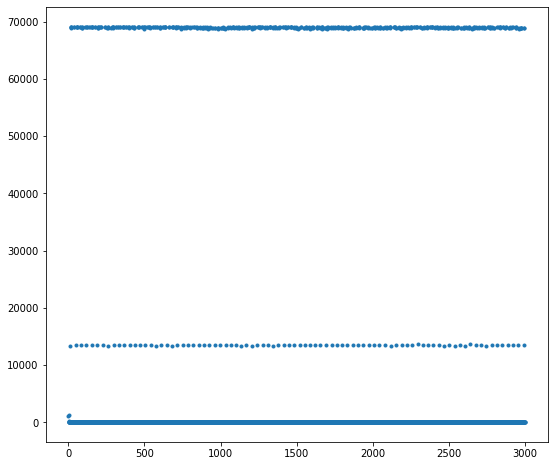

In [4]:
plt.figure(figsize=(9,8))
plt.plot(np.diff(K.Index.ByteOffset),'.')
plt.show()

In [5]:
msg_type_group = K.Index.groupby("MessageType")
msg_type_group["MessageSize"].sum()

MessageType
b'#CPO'       13572
b'#IIP'        1054
b'#IOP'        1332
b'#MRZ'    32556126
b'#SCL'        6612
b'#SKM'     1159680
b'#SPO'       13572
b'#SVP'         292
b'#SVT'      148308
Name: MessageSize, dtype: int64

In [8]:
iMRZ = K.Index["MessageType"] == "b'#MRZ'"
MRZIndex = K.Index[iMRZ]
MRZIndex.head()

K.OpenFiletoRead()
K.FID.seek(MRZIndex["ByteOffset"].iloc[0],0)
dg = K.read_EMdgmMRZ()

dga = np.array([dg["sounding"][k] for k in dg["sounding"].keys()])

#import xarray as xr
#sxr = xr.DataArray(dg["soundings"])


In [9]:
dga.shape
import bz2
import pickle
print(len(pickle.dumps(dga)))
print(len(bz2.compress(pickle.dumps(dga))))
print(len(bz2.compress(pickle.dumps(dga.T))))

128161
34148
34152


In [11]:
import pandas as pd
df  = pd.DataFrame(dg["sounding"])

In [12]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 40 columns):
soundingIndex                     400 non-null int64
txSectorNumb                      400 non-null int64
detectionType                     400 non-null int64
detectionMethod                   400 non-null int64
rejectionInfo1                    400 non-null int64
rejectionInfo2                    400 non-null int64
postProcessingInfo                400 non-null int64
detectionClass                    400 non-null int64
detectionConfidenceLevel          400 non-null int64
padding                           400 non-null int64
rangeFactor                       400 non-null float64
qualityFactor                     400 non-null float64
detectionUncertaintyVer_m         400 non-null float64
detectionUncertaintyHor_m         400 non-null float64
detectionWindowLength_sec         400 non-null float64
echoLength_sec                    400 non-null float64
WCBeamNumb                        4

In [13]:
df.describe()

,soundingIndex,txSectorNumb,detectionType,detectionMethod,rejectionInfo1,rejectionInfo2,postProcessingInfo,detectionClass,detectionConfidenceLevel,padding,...,deltaLatitude_deg,deltaLongitude_deg,z_reRefPoint_m,y_reRefPoint_m,x_reRefPoint_m,beamIncAngleAdj_deg,realTimeCleanInfo,SIstartRange_samples,SIcentreSample,SInumSamples
count,400.000000,400.000000,400.000000,400.000000,400.0,400.000000,400.0,400.0,400.0,400.000000,...,400.000000,400.000000,400.000000,400.000000,400.000000,400.0,400.0,400.000000,400.00000,400.000000
mean,199.500000,0.987500,0.315000,1.675000,0.0,89.585000,0.0,0.0,12.0,40779.535000,...,0.000021,0.000002,65.686470,-2.104997,-1.084838,0.0,0.0,4585.227500,13.34750,25.890000
std,115.614301,0.845062,0.729455,0.731925,0.0,21.491685,0.0,0.0,0.0,22759.659274,...,0.000794,0.000651,0.632947,101.862164,2.284960,0.0,0.0,1801.765084,6.59511,11.830164
min,0.000000,0.000000,0.000000,0.000000,0.0,40.000000,0.0,0.0,12.0,231.000000,...,-0.001348,-0.001127,64.267426,-177.686630,-5.135906,0.0,0.0,0.000000,0.00000,0.000000
25%,99.750000,0.000000,0.000000,2.000000,0.0,99.000000,0.0,0.0,12.0,13232.250000,...,-0.000667,-0.000557,65.117270,-90.105722,-3.113953,0.0,0.0,3218.750000,9.75000,19.000000
50%,199.500000,1.000000,0.000000,2.000000,0.0,99.000000,0.0,0.0,12.0,49350.500000,...,0.000024,0.000006,65.893391,-2.532523,-1.033805,0.0,0.0,4457.500000,15.00000,29.000000
75%,299.250000,2.000000,0.000000,2.000000,0.0,99.000000,0.0,0.0,12.0,60391.750000,...,0.000708,0.000564,66.083326,85.941576,1.229908,0.0,0.0,6029.250000,17.00000,33.000000
max,399.000000,2.000000,2.000000,2.000000,0.0,99.000000,0.0,0.0,12.0,65279.000000,...,0.001391,0.001123,66.914223,173.773376,2.349857,0.0,0.0,7761.000000,47.00000,63.000000


In [183]:
dff = pd.DataFrame()

In [184]:
dff["txSectorNumb"] = df["txSectorNumb"].astype('uint8')
dff["detectionType"] = df["detectionType"].astype('uint8')
dff["detectionMethod"] = df["detectionMethod"].astype('uint8')
dff["rejectioninfo1"] = df["rejectionInfo1"].astype('uint8')
dff["rejectioninfo2"] = df["rejectionInfo2"].astype('uint8')
dff["postprocessinginfo"] = 0

In [195]:
dfsparese = df.astype(pd.SparseDtype("int",0))
dfsparseint = df.select_dtypes(include="int").astype(pd.SparseDtype("int",0))
dfsparesefloat = df.select_dtypes(include="float")

In [196]:
dfsparese = pd.concat([dfsparseint,dfsparesefloat],axis=1)
print(len(pickle.dumps(df)))
print(len(pickle.dumps(dfsparese)))

130349
133805


In [208]:
len(pickle.dumps(dg))
print(len(bz2.compress(pickle.dumps(dg))))

47854


In [14]:
# How much memory does the typical MRZ record require on disk? 
import struct
hdr = struct.Struct("I4sBBHII").size 
pinginfo = struct.Struct("2Hf6BH11f2h2BHI3f2Hf2H6f4B2df").size
txsectinfo = struct.Struct("4B7f2BH").size 
rxsinfo = struct.Struct("4H4f4H").size
extradet = struct.Struct("HbB").size
snd = struct.Struct("H8BH6f2H18f4H").size
bdy = struct.Struct('2H8B').size
mrzsize = hdr + pinginfo + txsectinfo + rxsinfo + extradet + 400*snd + bdy
print(mrzsize)

48252


In [15]:
import struct

def write_EMdgmMRZ(FID,dg):
    ''' A method to write an MRZ datagram back to disk.'''
    
    write_EMdgmHeader(FID, dg['header'])
    write_EMdgmMpartition(FID, dg['partition'])
    write_EMdgmMbody(FID, dg['cmnPart'])
    write_EMdgmMRZ_pingInfo(FID, dg['pingInfo'])
    
    for sector in range(dg['pingInfo']['numTxSectors']):
        write_EMdgmMRZ_txSectorInfo(FID, dg['txSectorInfo'],sector)
    
    write_EMdgmMRZ_rxInfo(FID, dg['rxInfo'])
    
    for detclass in range(dg['rxInfo']['numExtraDetectionClasses']):
            write_EMdgmMRZ_extraDetClassInfo(FID,dg['extraDetClassInfo'],detclass)
            
    Nseabedimage_samples = 0
    for record in range(dg['rxInfo']['numExtraDetections'] +
                              dg['rxInfo']['numSoundingsMaxMain']):
        write_EMdgmMRZ_sounding(FID, dg['sounding'], record)
        Nseabedimage_samples += dg['sounding']['SInumSamples'][record]
        
    write_EMdgmMRZ_seabedImagery(FID, dg, Nseabedimage_samples)
    
    FID.write(struct.pack("I",dg['header']['numBytesDgm']))
    
def write_EMdgmMRZ_woImagery(FID,dg):
    ''' A method to write an MRZ datagram back to disk, but omitting the imagery data.'''
    
    # First we need to see how much space the imagery data will take. 
    Nseabedimage_samples = 0
    for record in range(dg['rxInfo']['numExtraDetections'] +
                              dg['rxInfo']['numSoundingsMaxMain']):
        Nseabedimage_samples += dg['sounding']['SInumSamples'][record]
    imageryBytes = Nseabedimage_samples * 2
    
    # Now we need to reset the total packet size.
    dg['header']['numBytesDgm'] -= imageryBytes

    # Now write the packet, just leave out the imagery 
    # data and set Nsamples  to 0.
    write_EMdgmHeader(FID, dg['header'])
    write_EMdgmMpartition(FID, dg['partition'])
    write_EMdgmMbody(FID, dg['cmnPart'])
    write_EMdgmMRZ_pingInfo(FID, dg['pingInfo'])
    
    for sector in range(dg['pingInfo']['numTxSectors']):
        write_EMdgmMRZ_txSectorInfo(FID, dg['txSectorInfo'],sector)
    
    write_EMdgmMRZ_rxInfo(FID, dg['rxInfo'])
    
    for detclass in range(dg['rxInfo']['numExtraDetectionClasses']):
            write_EMdgmMRZ_extraDetClassInfo(FID,dg['extraDetClassInfo'],detclass)
            
    Nseabedimage_samples = 0
    for record in range(dg['rxInfo']['numExtraDetections'] +
                              dg['rxInfo']['numSoundingsMaxMain']):
        
        # Zero out the number of imagery samples for each sounding.
        dg['sounding']['SInumSamples'][record] = 0
        write_EMdgmMRZ_sounding(FID, dg['sounding'], record)
        Nseabedimage_samples += dg['sounding']['SInumSamples'][record]
        
    # Don't write the imagery data. 
    #write_EMdgmMRZ_seabedImagery(FID, dg, Nseabedimage_samples)
    
    FID.write(struct.pack("I",dg['header']['numBytesDgm']))
    
def write_EMdgmHeader(FID, dg):
    ''' Method to write the datagram header.
       
    write_EMdgmHeader(FID, dg['header'])
       
    '''
    
    format_to_pack = "<1I4s2B1H2I"
        
    dg_seconds = int(dg['dgtime'])
    dg_nanoseconds = int((dg['dgtime'] - dg_seconds) * 1e9)
        
    FID.write(struct.pack(format_to_pack,
                        dg['numBytesDgm'],
                        dg['dgmType'],
                        dg['dgmVersion'],
                        dg['systemID'],
                        dg['echoSounderID'],
                        dg_seconds,
                        dg_nanoseconds))


def write_EMdgmMpartition(FID, dg):
    ''' A method to write the Partition Information
    
    write_EMdgmMpartition(FID, dg['partition'])
    
    '''
    
    format_to_pack = "<2H"
    FID.write(struct.pack(format_to_pack,
                         dg['numOfDgms'],
                         dg['dgmNum']))


def write_EMdgmMbody(FID, dg):
    ''' A method to write the datagram body information
    
    write_EMdgmMbody(FID, dg['cmnPart'])
    
    '''
    
    format_to_pack = "<2H8B"
    FID.write(struct.pack(format_to_pack,
                        dg['numBytesCmnPart'],
                        dg['pingCnt'],
                        dg['rxFansPerPing'],
                        dg['rxFanIndex'],
                        dg['swathsPerPing'],
                        dg['swathAlongPosition'],
                        dg['txTransducerInd'],
                        dg['rxTransducerInd'],
                        dg['numRxTransducers'],
                        dg['algorithmType']))

def write_EMdgmMRZ_pingInfo(FID, dg):
    '''A method to write MRZ ping info.
    
    write_EMdgmMRZ_pingInfo(FID, dg['pinginfo'])
    
    '''
    
    format_to_pack_a = "<2H1f6B1H11f2h2B1H1I3f2H1f2H6f4B"
    FID.write(struct.pack(format_to_pack_a,
                         dg['numBytesInfoData'],
                         dg['padding0'],
                         dg['pingRate_Hz'],
                         dg['beamSpacing'],
                         dg['depthMode'],
                         dg['subDepthMode'],
                         dg['distanceBtwSwath'],
                         dg['detectionMode'],
                         dg['pulseForm'],
                         dg['padding1'],
                         dg['frequencyMode_Hz'],
                         dg['freqRangeLowLim_Hz'],
                         dg['freqRangeHighLim_Hz'],
                         dg['maxTotalTxPulseLength_sec'],
                         dg['maxEffTxPulseLength_sec'],
                         dg['maxEffTxBandWidth_Hz'],
                         dg['absCoeff_dBPerkm'],
                         dg['portSectorEdge_deg'],
                         dg['starbSectorEdge_deg'],
                         dg['portMeanCov_deg'],
                         dg['stbdMeanCov_deg'],
                         dg['portMeanCov_m'],
                         dg['starbMeanCov_m'],
                         dg['modeAndStabilisation'],
                         dg['runtimeFilter1'],
                         dg['runtimeFilter2'],
                         dg['pipeTrackingStatus'],
                         dg['transmitArraySizeUsed_deg'],
                         dg['receiveArraySizeUsed_deg'],
                         dg['transmitPower_dB'],
                         dg['SLrampUpTimeRemaining'],
                         dg['padding2'],
                         dg['yawAngle_deg'],
                         dg['numTxSectors'],
                         dg['numBytesPerTxSector'],
                         dg['headingVessel_deg'],
                         dg['soundSpeedAtTxDepth_mPerSec'],
                         dg['txTransducerDepth_m'],
                         dg['z_waterLevelReRefPoint_m'],
                         dg['x_kmallToall_m'],
                         dg['y_kmallToall_m'],
                         dg['latLongInfo'],
                         dg['posSensorStatus'],
                         dg['attitudeSensorStatus'],
                         dg['padding3']))
    
    # For some reason, it doesn't work to do this all in one step, but it works broken up into two steps. *shrug*
    format_to_pack_b = "<2d1f"
    FID.write(struct.pack(format_to_pack_b,
                         dg['latitude_deg'],
                         dg['longitude_deg'],
                         dg['ellipsoidHeightReRefPoint_m']))


def write_EMdgmMRZ_txSectorInfo(FID, dg, sector):
    ''' Write MRZ txSectorInfo for single index "sector". 
    
    write_EMdgmMRZ_txSectorInfo(FID, dg['txSectorInfo'], sector)
    
    '''
    
    format_to_pack = "4B7f2B1H"
    FID.write(struct.pack(format_to_pack,
                         dg['txSectorNumb'][sector],
                         dg['txArrNumber'][sector],
                         dg['txSubArray'][sector],
                         dg['padding0'][sector],
                         dg['sectorTransmitDelay_sec'][sector],
                         dg['tiltAngleReTx_deg'][sector],
                         dg['txNominalSourceLevel_dB'][sector],
                         dg['txFocusRange_m'][sector],
                         dg['centreFreq_Hz'][sector],
                         dg['signalBandWidth_Hz'][sector],
                         dg['totalSignalLength_sec'][sector],
                         dg['pulseShading'][sector],
                         dg['signalWaveForm'][sector],
                         dg['padding1'][sector]))


def write_EMdgmMRZ_rxInfo(FID, dg):
    ''' Write MRZ rxInfo datagram.
    
        write_EMdgmMRZ_rxInfo(FID, dg['rxInfo'])
        
        '''
    
    format_to_pack = "4H4f4H"
    FID.write(struct.pack(format_to_pack,
                         dg['numBytesRxInfo'],
                         dg['numSoundingsMaxMain'],
                         dg['numSoundingsValidMain'],
                         dg['numBytesPerSounding'],
                         dg['WCSampleRate'],
                         dg['seabedImageSampleRate'],
                         dg['BSnormal_dB'],
                         dg['BSoblique_dB'],
                         dg['extraDetectionAlarmFlag'],
                         dg['numExtraDetections'],
                         dg['numExtraDetectionClasses'],
                         dg['numBytesPerClass']))



def write_EMdgmMRZ_extraDetClassInfo(FID,dg,detclass):
    ''' Write the MRZ sounding extra Detection Class information.
    
    write_EMdgmMRZ_extraDetClassInfo(FID,dg['extraDetClassInfo'],detclass)
    
    '''

    format_to_pack = "1H1b1B"
    FID.write(struct.pack(format_to_pack,
                         dg['numExtraDetInClass'][detclass],
                         dg['padding'][detclass],
                         dg['alarmFlag'][detclass]))


def write_EMdgmMRZ_sounding(FID, dg, record):
    ''' Write MRZ soundings records.
    
    write_EMdgmMRZ_sounding(FID, dg['sounding'], record)
    
    '''
    
    format_to_pack = "1H8B1H6f2H18f4H"
    
    FID.write(struct.pack(format_to_pack,
                         dg['soundingIndex'][record],
                         dg['txSectorNumb'][record],
                         dg['detectionType'][record],
                         dg['detectionMethod'][record],
                         dg['rejectionInfo1'][record],
                         dg['rejectionInfo2'][record],
                         dg['postProcessingInfo'][record],
                         dg['detectionClass'][record],
                         dg['detectionConfidenceLevel'][record],
                         dg['padding'][record],
                         dg['rangeFactor'][record],
                         dg['qualityFactor'][record],
                         dg['detectionUncertaintyVer_m'][record],
                         dg['detectionUncertaintyHor_m'][record],
                         dg['detectionWindowLength_sec'][record],
                         dg['echoLength_sec'][record],
                         dg['WCBeamNumb'][record],
                         dg['WCrange_samples'][record],
                         dg['WCNomBeamAngleAcross_deg'][record],
                         dg['meanAbsCoeff_dbPerkm'][record],
                         dg['reflectivity1_dB'][record],
                         dg['reflectivity2_dB'][record],
                         dg['receiverSensitivityApplied_dB'][record],
                         dg['sourceLevelApplied_dB'][record],
                         dg['BScalibration_dB'][record],
                         dg['TVG_dB'][record],
                         dg['beamAngleReRx_deg'][record],
                         dg['beamAngleCorrection_deg'][record],
                         dg['twoWayTravelTime_sec'][record],
                         dg['twoWayTravelTimeCorrection_sec'][record],
                         dg['deltaLatitude_deg'][record],
                         dg['deltaLongitude_deg'][record],
                         dg['z_reRefPoint_m'][record],
                         dg['y_reRefPoint_m'][record],
                         dg['x_reRefPoint_m'][record],
                         dg['beamIncAngleAdj_deg'][record],
                         dg['realTimeCleanInfo'][record],
                         dg['SIstartRange_samples'][record],
                         dg['SIcentreSample'][record],
                         dg['SInumSamples'][record]))


def write_EMdgmMRZ_seabedImagery(FID, dg, Nseabedimage_samples):
    ''' Write the MRZ seabedImagery datagram 
    
    write_EMdgmMRZ_seabedImagery(FID, dg['SIsample_desidB'])
    
    '''
    format_to_pack = str(Nseabedimage_samples) + "h"

    FID.write(struct.pack(format_to_pack,
                         *dg['SIsample_desidB']))
    
def write_EMdgmMRZ_sounding_woImagery(FID, dg, record):
    ''' Write MRZ soundings records.
    
    write_EMdgmMRZ_sounding(FID, dg['sounding'], record)
    
    '''
    
    format_to_pack = "1H8B1H6f2H18f4H"
    
    FID.write(struct.pack(format_to_pack,
                         dg['soundingIndex'][record],
                         dg['txSectorNumb'][record],
                         dg['detectionType'][record],
                         dg['detectionMethod'][record],
                         dg['rejectionInfo1'][record],
                         dg['rejectionInfo2'][record],
                         dg['postProcessingInfo'][record],
                         dg['detectionClass'][record],
                         dg['detectionConfidenceLevel'][record],
                         dg['padding'][record],
                         dg['rangeFactor'][record],
                         dg['qualityFactor'][record],
                         dg['detectionUncertaintyVer_m'][record],
                         dg['detectionUncertaintyHor_m'][record],
                         dg['detectionWindowLength_sec'][record],
                         dg['echoLength_sec'][record],
                         dg['WCBeamNumb'][record],
                         dg['WCrange_samples'][record],
                         dg['WCNomBeamAngleAcross_deg'][record],
                         dg['meanAbsCoeff_dbPerkm'][record],
                         dg['reflectivity1_dB'][record],
                         dg['reflectivity2_dB'][record],
                         dg['receiverSensitivityApplied_dB'][record],
                         dg['sourceLevelApplied_dB'][record],
                         dg['BScalibration_dB'][record],
                         dg['TVG_dB'][record],
                         dg['beamAngleReRx_deg'][record],
                         dg['beamAngleCorrection_deg'][record],
                         dg['twoWayTravelTime_sec'][record],
                         dg['twoWayTravelTimeCorrection_sec'][record],
                         dg['deltaLatitude_deg'][record],
                         dg['deltaLongitude_deg'][record],
                         dg['z_reRefPoint_m'][record],
                         dg['y_reRefPoint_m'][record],
                         dg['x_reRefPoint_m'][record],
                         dg['beamIncAngleAdj_deg'][record],
                         dg['realTimeCleanInfo'][record],
                         dg['SIstartRange_samples'][record],
                         dg['SIcentreSample'][record],
                         dg['SInumSamples'][record]))

    

 Here we want to test our code for reading and writing data from a file. First I'm just going to read from one file and write all packets except MRZ packets into another. 

In [16]:
K.Index.head()

,ByteOffset,MessageSize,MessageType
Time,,,
1.557762e+09,0,1054,b'#IIP'
1.557762e+09,1054,1332,b'#IOP'
1.557762e+09,2386,292,b'#SVP'
1.557762e+09,2678,68,b'#SVT'
1.557762e+09,2746,68,b'#SVT'


In [17]:
FIDout = open('compressiondata/test.kmall','wb')
K = kmall.kmall('compressiondata/0007_20190513_154724_ASVBEN.kmall')
K.index_file()
for moffset, msize, mtype in zip(K.Index['ByteOffset'],K.Index['MessageSize'],K.Index['MessageType']):
    K.FID.seek(moffset,0)
    if mtype == "b'#MRZ'":
        continue
        
    buffer = K.FID.read(msize)
    FIDout.write(buffer)
    
FIDout.close()

!ls -lh data/

total 66216
-rwxr-xr-x  1 vschmidt  1129769604    32M Dec  4 13:38 0007_20190513_154724_ASVBEN.kmall


Wow! that resulted in a very small file. Can we read this file?

In [18]:
t = kmall.kmall(filename='compressiondata/test.kmall')
t.index_file()
t.Index.head()

,ByteOffset,MessageSize,MessageType
Time,,,
1.557762e+09,0,1054,b'#IIP'
1.557762e+09,1054,1332,b'#IOP'
1.557762e+09,2386,292,b'#SVP'
1.557762e+09,2678,68,b'#SVT'
1.557762e+09,2746,68,b'#SVT'


Looks good!

Ok. now lets see if we can interpret the MRZ datagram and then re-write the interpreted data back to the file and still read it. 

In [19]:
FIDout = open('compressiondata/test.kmall','wb')

for offset, size, mtype in zip(K.Index['ByteOffset'],K.Index['MessageSize'],K.Index['MessageType']):
    K.FID.seek(offset,0)
    if mtype == "b'#MRZ'":
        dg = K.read_EMdgmMRZ()
        write_EMdgmMRZ(FIDout,dg)
    else:
        buffer = K.FID.read(size)
        FIDout.write(buffer)
    
FIDout.close()

!ls -lh data/

t = kmall.kmall(filename='compressiondata/test.kmall')
t.index_file()
print(t.Index.iloc[0:20,:])
print(K.Index.iloc[0:20,:])
print(K.Index.equals(t.Index))

total 66216
-rwxr-xr-x  1 vschmidt  1129769604    32M Dec  4 13:38 0007_20190513_154724_ASVBEN.kmall
              ByteOffset  MessageSize MessageType
Time                                             
1.557762e+09           0         1054     b'#IIP'
1.557762e+09        1054         1332     b'#IOP'
1.557762e+09        2386          292     b'#SVP'
1.557762e+09        2678           68     b'#SVT'
1.557762e+09        2746           68     b'#SVT'
1.557762e+09        2814           68     b'#SVT'
1.557762e+09        2882           68     b'#SVT'
1.557762e+09        2950           68     b'#SVT'
1.557762e+09        3018           68     b'#SVT'
1.557762e+09        3086           68     b'#SVT'
1.557762e+09        3154           68     b'#SVT'
1.557762e+09        3222           68     b'#SVT'
1.557762e+09        3290        13368     b'#SKM'
1.557762e+09       16658           68     b'#SVT'
1.557762e+09       16726           68     b'#SVT'
1.557762e+09       16794           68     b'#SVT'

Ok! So after some debugging, we now have read a file, interpreted the MRZ datagram into python data structures (instead of just a binary blob), and then successfully re-written that datagram into a new file. After indexing the new file, it's index and byte count are identical to the original. Of course, this does not mean they are exactly the same. 

One detail that I am unsure about is how byte alignment works. The spec indicates that the structs are written with 4-byte alignmnet. And it is true, that when reading the file, there are at least two places in which a single call to `struct.unpack` will fail to fully interpret the data, resulting in a 2-byte shift partway through. Splitting the read and converstion into two calls fixed the problem. My suspician is that this is a result of a byte alignment problem that I don't understand. And because I don't understand it, I'm not sure how to address it when writing the data. 

I can check to see if the files are identical with an md5 checksum, and they are not. :(

In [20]:
!md5 data/0007_20190513_154724_ASVBEN.kmall
!md5 data/test.kmall

MD5 (data/0007_20190513_154724_ASVBEN.kmall) = f22900b2bdcaff47001cac43403d3bee
md5: data/test.kmall: No such file or directory


However, I was able, just now, to read the test.all file within Qimera, see the bathy data, create a surface, see all the navigation and it appears to be just fine!

Ok, so now we need to create a new data format which improves on the storage and compressibility of the existing one. 

First step - loose the Imagery. To do this, I've modified the method to write the MRZ record to zero out the number of imagery samples and then comment out the writing of the imagery data. 

In [112]:
FIDout = open('compressiondata/test_woImagery.kmall','wb')
K = kmall.kmall('compressiondata/0007_20190513_154724_ASVBEN.kmall')
K.index_file()
for offset, size, mtype in zip(K.Index['ByteOffset'],K.Index['MessageSize'],K.Index['MessageType']):
    K.FID.seek(offset,0)
    if mtype == "b'#MRZ'":
        dg = K.read_EMdgmMRZ()
        write_EMdgmMRZ_woImagery(FIDout,dg)
    else:
        buffer = K.FID.read(size)
        FIDout.write(buffer)
    
FIDout.close()

!ls -lh data/

t = kmall.kmall(filename='compressiondata/test_woImagery.kmall')
t.index_file()
t.Index.head()

total 183008
-rwxr-xr-x  1 vschmidt  1129769604    32M Dec  4 13:38 0007_20190513_154724_ASVBEN.kmall
-rw-r--r--  1 vschmidt  1129769604    32M Feb  8 17:02 test.kmall
-rw-r--r--  1 vschmidt  1129769604    23M Feb  8 17:13 test_woImagery.kmall


,ByteOffset,MessageSize,MessageType
Time,,,
1.557762e+09,0,1054,b'#IIP'
1.557762e+09,1054,1332,b'#IOP'
1.557762e+09,2386,292,b'#SVP'
1.557762e+09,2678,68,b'#SVT'
1.557762e+09,2746,68,b'#SVT'


This seems to have worked! We dropped the file size by about 30%. It's a start. Lets take a closer look at the packets to see that everything is where it we expect and where else we might gain some efficiency. 

In [114]:
msg_type_groupK = K.Index.groupby("MessageType")
msg_type_groupK["MessageSize"].sum()

MessageType
b'#CPO'       13572
b'#IIP'        1054
b'#IOP'        1332
b'#MRZ'    32556126
b'#SCL'        6612
b'#SKM'     1159680
b'#SPO'       13572
b'#SVP'         292
b'#SVT'      148308
Name: MessageSize, dtype: int64

In [115]:
msg_type_groupt = t.Index.groupby("MessageType")
msg_type_groupt["MessageSize"].sum()

MessageType
b'#CPO'       13572
b'#IIP'        1054
b'#IOP'        1332
b'#MRZ'    22808928
b'#SCL'        6612
b'#SKM'     1159680
b'#SPO'       13572
b'#SVP'         292
b'#SVT'      148308
Name: MessageSize, dtype: int64

Ok. lets now see where else we can gain some efficiency. Sounding records are parsed and the 39 fields for each sounding record are stored in a table once parsed. Lets have alook at the first 20 or so records from each:

In [133]:
mrzoffsets = [x for x,y in zip(K.msgoffset, K.msgtype) if y == "b'#MRZ'"]
K.FID.seek(mrzoffsets[0],0)

dg = K.read_EMdgmMRZ()

for k in dg['sounding']:
    print(k + ":")
    print(dg['sounding'][k][:20])


soundingIndex:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
txSectorNumb:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
detectionType:
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
detectionMethod:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
rejectionInfo1:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
rejectionInfo2:
[40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]
postProcessingInfo:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
detectionClass:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
detectionConfidenceLevel:
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
padding:
[33152, 33667, 39055, 42667, 42417, 42663, 48567, 42689, 48823, 44739, 49859, 51885, 50892, 55758, 49348, 53466, 48331, 53708, 54237, 49378]
rangeFactor:
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0

Many of these fields repeat, or nearly so, from record to record. So we need not write them in every record. But as a first go, we might just try re-writing the data, writing one field for all records at a time, and then compressing the result. 

In [21]:

def compressSoundings(dg):
    ''' A method to compress the soundings table by column rather than by row.'''
    record = len(dg['soundingIndex'])
    format_to_pack = "1H8B1H6f2H18f4H"
    

    buffer = struct.pack(str(record)+"H", *dg['soundingIndex'])

    buffer += struct.pack(str(record)+"B", *dg['txSectorNumb'])
    buffer += struct.pack(str(record)+"B", *dg['detectionType'])
    buffer += struct.pack(str(record)+"B", *dg['detectionMethod'])
    buffer += struct.pack(str(record)+"B", *dg['rejectionInfo1'])
    buffer += struct.pack(str(record)+"B", *dg['rejectionInfo2'])
    buffer += struct.pack(str(record)+"B", *dg['postProcessingInfo'])
    buffer += struct.pack(str(record)+"B", *dg['detectionClass'])
    buffer += struct.pack(str(record)+"B", *dg['detectionConfidenceLevel'])

    buffer += struct.pack(str(record)+"H", *dg['padding'])

    buffer += struct.pack(str(record)+"f", *dg['rangeFactor'])
    buffer += struct.pack(str(record)+"f", *dg['qualityFactor'])
    buffer += struct.pack(str(record)+"f", *dg['detectionUncertaintyVer_m'])
    buffer += struct.pack(str(record)+"f", *dg['detectionUncertaintyHor_m'])
    buffer += struct.pack(str(record)+"f", *dg['detectionWindowLength_sec'])
    buffer += struct.pack(str(record)+"f", *dg['echoLength_sec'])

    buffer += struct.pack(str(record)+"H", *dg['WCBeamNumb'])
    buffer += struct.pack(str(record)+"H", *dg['WCrange_samples'])

    buffer += struct.pack(str(record)+"f", *dg['WCNomBeamAngleAcross_deg'])
    buffer += struct.pack(str(record)+"f", *dg['meanAbsCoeff_dbPerkm'])
    buffer += struct.pack(str(record)+"f", *dg['reflectivity1_dB'])
    buffer += struct.pack(str(record)+"f", *dg['reflectivity2_dB'])
    buffer += struct.pack(str(record)+"f", *dg['receiverSensitivityApplied_dB'])
    buffer += struct.pack(str(record)+"f", *dg['sourceLevelApplied_dB'])
    buffer += struct.pack(str(record)+"f", *dg['BScalibration_dB'])
    buffer += struct.pack(str(record)+"f", *dg['TVG_dB'])
    buffer += struct.pack(str(record)+"f", *dg['beamAngleReRx_deg'])
    buffer += struct.pack(str(record)+"f", *dg['beamAngleCorrection_deg'])
    buffer += struct.pack(str(record)+"f", *dg['twoWayTravelTime_sec'])
    buffer += struct.pack(str(record)+"f", *dg['twoWayTravelTimeCorrection_sec'])
    buffer += struct.pack(str(record)+"f", *dg['deltaLatitude_deg'])
    buffer += struct.pack(str(record)+"f", *dg['deltaLongitude_deg'])
    buffer += struct.pack(str(record)+"f", *dg['z_reRefPoint_m'])
    buffer += struct.pack(str(record)+"f", *dg['y_reRefPoint_m'])
    buffer += struct.pack(str(record)+"f", *dg['x_reRefPoint_m'])
    buffer += struct.pack(str(record)+"f", *dg['beamIncAngleAdj_deg'])
    
    buffer += struct.pack(str(record)+"H", *dg['realTimeCleanInfo'])
    buffer += struct.pack(str(record)+"H", *dg['SIstartRange_samples'])
    buffer += struct.pack(str(record)+"H", *dg['SIcentreSample'])
    buffer += struct.pack(str(record)+"H", *dg['SInumSamples'])

    return bz2.compress(buffer)
    

def compressSoundings2(dg):
    ''' Compresses soundings data, in their native record format. 
    This method is worse than re-arranging the data into like fields
    first as is down in compressedSoundings()'''
    format_to_pack = "1H8B1H6f2H18f4H"

    for record in range(len(dg['soundingIndex'])):
    
        if record == 0:
            buffer = struct.pack(format_to_pack,
                         dg['soundingIndex'][record],
                         dg['txSectorNumb'][record],
                         dg['detectionType'][record],
                         dg['detectionMethod'][record],
                         dg['rejectionInfo1'][record],
                         dg['rejectionInfo2'][record],
                         dg['postProcessingInfo'][record],
                         dg['detectionClass'][record],
                         dg['detectionConfidenceLevel'][record],
                         dg['padding'][record],
                         dg['rangeFactor'][record],
                         dg['qualityFactor'][record],
                         dg['detectionUncertaintyVer_m'][record],
                         dg['detectionUncertaintyHor_m'][record],
                         dg['detectionWindowLength_sec'][record],
                         dg['echoLength_sec'][record],
                         dg['WCBeamNumb'][record],
                         dg['WCrange_samples'][record],
                         dg['WCNomBeamAngleAcross_deg'][record],
                         dg['meanAbsCoeff_dbPerkm'][record],
                         dg['reflectivity1_dB'][record],
                         dg['reflectivity2_dB'][record],
                         dg['receiverSensitivityApplied_dB'][record],
                         dg['sourceLevelApplied_dB'][record],
                         dg['BScalibration_dB'][record],
                         dg['TVG_dB'][record],
                         dg['beamAngleReRx_deg'][record],
                         dg['beamAngleCorrection_deg'][record],
                         dg['twoWayTravelTime_sec'][record],
                         dg['twoWayTravelTimeCorrection_sec'][record],
                         dg['deltaLatitude_deg'][record],
                         dg['deltaLongitude_deg'][record],
                         dg['z_reRefPoint_m'][record],
                         dg['y_reRefPoint_m'][record],
                         dg['x_reRefPoint_m'][record],
                         dg['beamIncAngleAdj_deg'][record],
                         dg['realTimeCleanInfo'][record],
                         dg['SIstartRange_samples'][record],
                         dg['SIcentreSample'][record],
                         dg['SInumSamples'][record])
        else:
            buffer += struct.pack(format_to_pack,
                         dg['soundingIndex'][record],
                         dg['txSectorNumb'][record],
                         dg['detectionType'][record],
                         dg['detectionMethod'][record],
                         dg['rejectionInfo1'][record],
                         dg['rejectionInfo2'][record],
                         dg['postProcessingInfo'][record],
                         dg['detectionClass'][record],
                         dg['detectionConfidenceLevel'][record],
                         dg['padding'][record],
                         dg['rangeFactor'][record],
                         dg['qualityFactor'][record],
                         dg['detectionUncertaintyVer_m'][record],
                         dg['detectionUncertaintyHor_m'][record],
                         dg['detectionWindowLength_sec'][record],
                         dg['echoLength_sec'][record],
                         dg['WCBeamNumb'][record],
                         dg['WCrange_samples'][record],
                         dg['WCNomBeamAngleAcross_deg'][record],
                         dg['meanAbsCoeff_dbPerkm'][record],
                         dg['reflectivity1_dB'][record],
                         dg['reflectivity2_dB'][record],
                         dg['receiverSensitivityApplied_dB'][record],
                         dg['sourceLevelApplied_dB'][record],
                         dg['BScalibration_dB'][record],
                         dg['TVG_dB'][record],
                         dg['beamAngleReRx_deg'][record],
                         dg['beamAngleCorrection_deg'][record],
                         dg['twoWayTravelTime_sec'][record],
                         dg['twoWayTravelTimeCorrection_sec'][record],
                         dg['deltaLatitude_deg'][record],
                         dg['deltaLongitude_deg'][record],
                         dg['z_reRefPoint_m'][record],
                         dg['y_reRefPoint_m'][record],
                         dg['x_reRefPoint_m'][record],
                         dg['beamIncAngleAdj_deg'][record],
                         dg['realTimeCleanInfo'][record],
                         dg['SIstartRange_samples'][record],
                         dg['SIcentreSample'][record],
                         dg['SInumSamples'][record])
                
    
    return bz2.compress(buffer)

def write_EMdgmMRZ_compressed_sounding_woImagery(FID, buffer):
    ''' Write MRZ soundings records.
    
    write_EMdgmMRZ_sounding(FID, dg['sounding'])
    
    '''
    FID.write(struct.pack('I',len(buffer)))
    FID.write(buffer)
    return



def write_EMdgmMRZ_woImageryCompressedSoundings(FID,dg):
    ''' A method to write an MRZ datagram back to disk, but omitting the imagery data.'''
    
    # First we need to see how much space the imagery data will take. 
    Nseabedimage_samples = 0
    for record in range(dg['rxInfo']['numExtraDetections'] +
                              dg['rxInfo']['numSoundingsMaxMain']):
        Nseabedimage_samples += dg['sounding']['SInumSamples'][record]
    imageryBytes = Nseabedimage_samples * 2
    
    # Now we need to reset the total packet size.
    dg['header']['numBytesDgm'] -= imageryBytes
    
    # And we need to create a new MRZ packet type to hold compressed data.
    dg['header']['dgmType'] = b'#CRZ'
    
    
    soundingsBuffer = compressSoundings(dg['sounding'])

    # Reduce the datagram size by the difference in size of the 
    # original and compressed sounding data. The size of the 
    # sounding data is encoded with it as a 5-byte int.
    dg['header']['numBytesDgm'] -= (len(dg['sounding']['soundingIndex']) * 120 - (len(soundingsBuffer) + 4))

    # Now write the packet, just leave out the imagery 
    # data and set Nsamples  to 0.
    write_EMdgmHeader(FID, dg['header'])
    write_EMdgmMpartition(FID, dg['partition'])
    write_EMdgmMbody(FID, dg['cmnPart'])
    write_EMdgmMRZ_pingInfo(FID, dg['pingInfo'])
    
    for sector in range(dg['pingInfo']['numTxSectors']):
        write_EMdgmMRZ_txSectorInfo(FID, dg['txSectorInfo'],sector)
    
    write_EMdgmMRZ_rxInfo(FID, dg['rxInfo'])
    
    for detclass in range(dg['rxInfo']['numExtraDetectionClasses']):
            write_EMdgmMRZ_extraDetClassInfo(FID,dg['extraDetClassInfo'],detclass)
    
    write_EMdgmMRZ_compressed_sounding_woImagery(FID,soundingsBuffer)
        
    # Don't write the imagery data. 
    #write_EMdgmMRZ_seabedImagery(FID, dg, Nseabedimage_samples)
    
    FID.write(struct.pack("I",dg['header']['numBytesDgm']))

In [22]:
FIDout = open('compressiondata/test_woImagery_compressedsoundings.kmall','wb')
K = kmall.kmall('compressiondata/0007_20190513_154724_ASVBEN.kmall')
K.index_file()
for offset, size, mtype in zip(K.Index['ByteOffset'],K.Index['MessageSize'],K.Index['MessageType']):
    K.FID.seek(offset,0)
    if mtype == "b'#MRZ'":
        dg = K.read_EMdgmMRZ()
        write_EMdgmMRZ_woImageryCompressedSoundings(FIDout,dg)    
    else:
        buffer = K.FID.read(size)
        FIDout.write(buffer)
    
FIDout.close()

!ls -lh compressiondata/

t = kmall.kmall(filename='compressiondata/test_woImagery_compressedsoundings.kmall')
t.index_file()
t.Index.head()
print(t.Index)


total 510208
-rwxr-xr-x  1 vschmidt  1129769604    32M Feb  6 15:58 0007_20190513_154724_ASVBEN.kmall
-rwxr-xr-x  1 vschmidt  1129769604    20M Feb  8 21:24 0007_20190513_154724_ASVBEN.kmall2.bz2
-rw-r--r--  1 vschmidt  1129769604    32M Feb 11 06:18 test.kmall
-rw-r--r--  1 vschmidt  1129769604    12M Feb  9 21:12 test_encodedcompressedsoundingsandimagery_p1.kmall
-rw-r--r--  1 vschmidt  1129769604    12M Feb  9 21:11 test_encodedcompressedsoundingsandimagery_p4.kmall
-rw-r--r--  1 vschmidt  1129769604    23M Feb  8 20:31 test_woImagery.kmall
-rw-r--r--  1 vschmidt  1129769604    15M Feb 11 06:25 test_woImagery_compressedsoundings.kmall
-rw-r--r--  1 vschmidt  1129769604    15M Feb  8 21:29 test_woImagery_compressedsoundings.kmall.bz2
-rw-r--r--  1 vschmidt  1129769604    16M Feb  8 21:32 test_woImagery_compressedsoundings_Native.kmall.bz2
-rw-r--r--@ 1 vschmidt  1129769604    12M Feb 10 15:32 test_woImagery_encodedcompressedsoundings.kmall
-rw-r--r--  1 vschmidt  1129769604    53M Fe

In [488]:
msg_type_groupt = K.Index.groupby("MessageType")
msg_type_groupt["MessageSize"].sum()

MessageType
b'#CPO'       13572
b'#IIP'        1054
b'#IOP'        1332
b'#MRZ'    32556126
b'#SCL'        6612
b'#SKM'     1159680
b'#SPO'       13572
b'#SVP'         292
b'#SVT'      148308
Name: MessageSize, dtype: int64

In [489]:
msg_type_groupt = t.Index.groupby("MessageType")
msg_type_groupt["MessageSize"].sum()

MessageType
b'#CPO'       13572
b'#CRZ'    14901788
b'#IIP'        1054
b'#IOP'        1332
b'#SCL'        6612
b'#SKM'     1159680
b'#SPO'       13572
b'#SVP'         292
b'#SVT'      148308
Name: MessageSize, dtype: int64

Ok. Compressing the sounding data definitely helps. I've done it two ways here, and by re-ordering the data into chucks of like fields, I get about about a 12% reduction over compressing the sounding data in its native form. 

    -rw-r--r--  1 vschmidt  1129769604    15M Feb  8 21:29 test_woImagery_compressedsoundings.kmall
    -rw-r--r--  1 vschmidt  1129769604    17M Feb  8 21:32 test_woImagery_compressedsoundings_Native.kmall

A second compression is not likely to improve this however. Lets try with bzip2:

    -rw-r--r--  1 vschmidt  1129769604    15M Feb  8 21:29 test_woImagery_compressedsoundings.kmall.bz2
    -rw-r--r--  1 vschmidt  1129769604    16M Feb  8 21:32 test_woImagery_compressedsoundings_Native.kmall.bz2

An interesting result. Compressing the file having no imagery and soundings reordered and then pre-compressed produces no real decrease in file size for this file. It is as though we've squeezed out all compression effiency from the file. Further, compressing the file having no imagery and soundings compressed but in their native format does reduce the file size somewhat, but not as well as the file containing the reorded data. There is, indeed, advantage in reordering the data. 

In looking at the file format further, although there are some large datagrams whose storage could be optimized, they are so rare compared to the soundings datagram that we are likely to see better results for our efforts if we focus further on the soundings datagram. 

Within the soundings datagram there are many fields defined as floats that could likely be bit packed into short integers or smaller. 

The "rangeFactor" field is 100.0 for every sounding in the first ping. The documentation states that units are % and this field will always be 100.0 for the main detection. Thus unless we have multiple detection classes this is wasted space - we could omit it altogether. This would save 4 bytes

The Quality factor is the depth uncertainty expressed as a percent of water depth. Were this encoded in unsigned 8-bit integers it could be expressd to 100%/255 = 0.3%. That seems sufficient and would save 3 bytes.

The detectionUncertainty_VerM field expresses the vertical uncertainty of the sounding in meters. The documentation states that it is calculated from the quality factor field. However, if the quaity factor field is divided by 100 and multiplied by the z_reRefPoint_m field (e.g. the depth) the values do not match this field. If it did, we could omit this field altogether and calculate it from the QF above. In any event, reasonable values for this field range from 1 cm to 10% of the Challenger Deep 10994 m, or about 1000 m (Ten Percent of WD is very pessimmestic for EM systems!) So an unsigned short expressed in cm could express this, saving two bytes. 

Presumably horizontal uncertainty could be similarly encoded, saving two bytes. 

detectionWindowLength_sec for our test data file ranges from about 0.1 ms to 2.8 ms, but it is not clear how this might change across EM systems and water depths. Presumably it would never be less than the 1/sample rate of the highest bandwidth system and never longer than the likeliy footprint of an outer beam in Challeger Deep. It is one that generally varies smoothly and hence could be differentially encoded. 


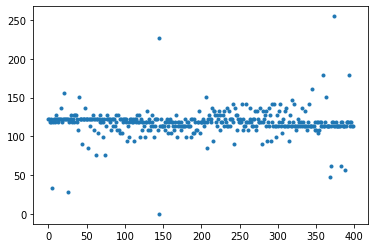

[0.002252159873023629, 0.002284799935296178, 0.0023174399975687265, 0.0023174399975687265, 0.0023500798270106316, 0.0023500798270106316, 0.0017625599866732955, 0.0017625599866732955, 0.0017951999325305223, 0.001827839994803071]
[0.00225216 0.0022848  0.00231744 0.00231744 0.00235008 0.00235008
 0.00176256 0.00176256 0.0017952  0.00182784]


In [281]:

maxv = np.max(np.diff(dg['sounding']['detectionWindowLength_sec']))
minv = np.min(np.diff(dg['sounding']['detectionWindowLength_sec']))
mu = np.mean(np.diff(dg['sounding']['detectionWindowLength_sec']))
tmp = (np.diff(dg['sounding']['detectionWindowLength_sec']) - minv) / (maxv-minv) * 255.0
plt.plot(tmp,'.')
plt.show()
#tmp2 = tmp * (maxv-minv / 255.0) + minv)
orig = np.cumsum([dg['sounding']['detectionWindowLength_sec'][0]] + list((tmp * (maxv-minv) / 255.0) + minv))

#orig = np.cumsum([dg['sounding']['detectionWindowLength_sec'][0]] + list(np.diff(dg['sounding']['detectionWindowLength_sec'])))

print(dg['sounding']['detectionWindowLength_sec'][0:10])
#print(['{:.4f}'.format(item) for item in orig[0:10]])
print(orig[0:10])


In [235]:
tmp = np.array(dg['sounding']['qualityFactor'])/100.0 * np.array(dg['sounding']['z_reRefPoint_m']) 
print(['{:.2f}'.format(item) for item in tmp[0:10]])
print(['{:.2f}'.format(item) for item in dg['sounding']['detectionUncertaintyVer_m'][0:10]])

['0.28', '0.24', '0.28', '0.10', '0.06', '0.23', '0.17', '0.05', '0.08', '0.03']
['0.30', '0.26', '0.30', '0.10', '0.07', '0.24', '0.18', '0.05', '0.08', '0.03']


Here's a generic recipe for differntial encoding of a field into a uint8 or uint16. It could be made incrementally better by passing the desired precision somehow and automatically choosing uint8 or uint16. But for now, we'll manage this manually.

In [23]:
def encodeArrayIntoUintX(A,res):
    ''' Differential encoding of an array of values into a byte array
    
    A:   An array of values
    res: Desired resolution. This determines whether the encoding is
         in an 8-bit or 16-bit array. Details provided below. 
    
    returns: bytes buffer containing packed values and metadata to unpack it.
    
    The data is differentially encoded, meaning that the difference 
    in sequential values is calculated, then the minimum differential value
    is subtracted off the array before scaling each value by max_bits / (max-min).
    
    max_bits is 255 for uint8 encoding and 65535 for uint16 encoding. To 
    determine the encoding, (max-min) / max_bits is compared to the desired 
    resolution to ensure the minimum increment falls below it. uint8 is checked
    first, if it fails, uint16 is checked. If it also fails, uint16 is 
    used anyway and a loss-of-data warning is issued. 
    
    A buffer is created from the result containing everything needed to 
    decipher it. Specifically:
    
    The first value of the original array as a 4-byte float
    Min difference values as 4-byte float.
    Max difference value as a 4-byte float.
    The number of bits used in the encoding (8 or 16) as a uint8.
    The number of difference values (len(A)-1) as an 4-byte unsigned int
    The array of scaled difference values cast to unsigned "max_bits" integers 
    
    '''
    if isinstance(A,list):
        A = np.array(A)
    
    dA = np.diff(A.flatten())
    #if isinstance(A,np.ndarray):
    #    dA = np.diff(A.flatten())
    #else:
    #    dA = np.diff(A)
        
    maxv = np.max(dA)
    minv = np.min(dA)

    if ((maxv - minv) / 255.0) < res:
        bits = 8
    elif ((maxv - minv) / 65535.0) < res:
        bits = 16
    else:
        #print("CANNOT Maintain Resolution - Loss of Data!")
        #bits = 16
        return None
        
    if maxv == minv:
        # Value is constant. 
        scaleFactor = 1.0
    else:
        if bits == 8:
            scaleFactor = 255.0 / (maxv-minv)
        elif bits == 16:
            scaleFactor = 65535.0 / (maxv-minv)
    
    tmp = (((dA-minv) * scaleFactor)).astype(int)
    
    # This bullshit gets around an apparant bug in the struct module. 
    if isinstance(A[0],np.ndarray):
        tmp2 = A[0].tolist()
    else:
        tmp2 = A[0]

    if isinstance(tmp2, np.int64) or isinstance(tmp2, np.float64):
        buffer = struct.pack('f', tmp2)
    else:
        buffer = struct.pack('f', tmp2[0])
    #buffer = struct.pack('f',float(A[0][0]))
    
    N = len(tmp)
    buffer += struct.pack('f', minv)
    buffer += struct.pack('f', maxv)  
    buffer += struct.pack('I',N)
    buffer += struct.pack('B', bits)
    if bits == 8:
        buffer += struct.pack(str(N) + 'B', *tmp)
    if bits == 16:
        buffer += struct.pack(str(N) + 'H', *tmp)

    return buffer

def decodeUintXintoArray(buffer):
    ''' Decodes encoded data from X-bit unsigned integers into an array.
    See encodeArrayIntoUintX.'''
    
    fields = struct.unpack('fffIB',buffer[0:17])
    A0 = fields[0]
    minv = fields[1]
    maxv = fields[2]
    N = fields[3]
    bits = fields[4]

    if bits == 8:
        dA = struct.unpack(str(N) + 'B',buffer[17:(17 + N)])
        bytesDecoded = 17 + N
    elif bits == 16:
        dA = struct.unpack(str(N) + 'H',buffer[17:(17 + N*2)])
        bytesDecoded = 17 + (N * 2)
    if bits == 8:
        orig = np.cumsum([A0] + list((np.array([float(x) for x in dA]) * (maxv-minv) / 255.0) + minv))
    elif bits == 16:
        orig = np.cumsum([A0] + list((np.array([float(x) for x in dA]) * (maxv-minv) / 65535.0) + minv))

    
    
    return (orig, bytesDecoded)

# Testing this mess.
a = np.arange(10)
buffer = encodeArrayIntoUintX(a,.1)
b, bytesdecoded = decodeUintXintoArray(buffer)
print(a)
print(b)
import pickle
print(len(pickle.dumps(a)))
print(len(pickle.dumps(buffer)))
a = np.random.rand(1,10) * 10

print(a)
buffer = encodeArrayIntoUintX(a.tolist(),.01)
if buffer is not None:
    b, bytesdecoded = decodeUintXintoArray(buffer)
    print(a-b)
    print(len(pickle.dumps(a)))
    print(len(pickle.dumps(buffer)))
# Test how to decode in middle of buffer.
N = len(buffer)
buffer += encodeArrayIntoUintX(a.tolist(),.1)
c, bytesdecoded = decodeUintXintoArray(buffer[N:])
print(a-c)

[0 1 2 3 4 5 6 7 8 9]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
235
33
[[1.92841382 3.55085847 6.64504709 2.87631553 6.49540098 0.65557925
  4.6214081  3.88372371 1.46148345 3.12351176]]
[[-4.96046628e-08  3.68021052e-05  1.09676693e-04  2.45301989e-04
   3.31769860e-04  3.31857380e-04  3.31810285e-04  4.18666627e-04
   4.23845743e-04  5.43454936e-04]]
237
42
[[-4.96046628e-08  2.28117169e-03  1.50721406e-02  4.81251864e-02
   8.59170633e-02  8.59171508e-02  8.59171037e-02  1.12188272e-01
   1.45858995e-01  1.49270346e-01]]


In [30]:
def compressSoundings(dg):
    ''' A method to compress the soundings table by column rather than by row.'''
    record = len(dg['soundingIndex'])
    format_to_pack = "1H8B1H6f2H18f4H"
    

    buffer = struct.pack(str(record)+"H", *dg['soundingIndex'])

    buffer += struct.pack(str(record)+"B", *dg['txSectorNumb'])
    buffer += struct.pack(str(record)+"B", *dg['detectionType'])
    buffer += struct.pack(str(record)+"B", *dg['detectionMethod'])
    buffer += struct.pack(str(record)+"B", *dg['rejectionInfo1'])
    buffer += struct.pack(str(record)+"B", *dg['rejectionInfo2'])
    buffer += struct.pack(str(record)+"B", *dg['postProcessingInfo'])
    buffer += struct.pack(str(record)+"B", *dg['detectionClass'])
    buffer += struct.pack(str(record)+"B", *dg['detectionConfidenceLevel'])

    buffer += struct.pack(str(record)+"H", *dg['padding'])

    buffer += struct.pack(str(record)+"f", *dg['rangeFactor'])
    buffer += struct.pack(str(record)+"f", *dg['qualityFactor'])
    buffer += struct.pack(str(record)+"f", *dg['detectionUncertaintyVer_m'])
    buffer += struct.pack(str(record)+"f", *dg['detectionUncertaintyHor_m'])
    buffer += struct.pack(str(record)+"f", *dg['detectionWindowLength_sec'])
    buffer += struct.pack(str(record)+"f", *dg['echoLength_sec'])

    buffer += struct.pack(str(record)+"H", *dg['WCBeamNumb'])
    buffer += struct.pack(str(record)+"H", *dg['WCrange_samples'])

    buffer += struct.pack(str(record)+"f", *dg['WCNomBeamAngleAcross_deg'])
    buffer += struct.pack(str(record)+"f", *dg['meanAbsCoeff_dbPerkm'])
    buffer += struct.pack(str(record)+"f", *dg['reflectivity1_dB'])
    buffer += struct.pack(str(record)+"f", *dg['reflectivity2_dB'])
    buffer += struct.pack(str(record)+"f", *dg['receiverSensitivityApplied_dB'])
    buffer += struct.pack(str(record)+"f", *dg['sourceLevelApplied_dB'])
    buffer += struct.pack(str(record)+"f", *dg['BScalibration_dB'])
    buffer += struct.pack(str(record)+"f", *dg['TVG_dB'])
    buffer += struct.pack(str(record)+"f", *dg['beamAngleReRx_deg'])
    buffer += struct.pack(str(record)+"f", *dg['beamAngleCorrection_deg'])
    buffer += struct.pack(str(record)+"f", *dg['twoWayTravelTime_sec'])
    buffer += struct.pack(str(record)+"f", *dg['twoWayTravelTimeCorrection_sec'])
    buffer += struct.pack(str(record)+"f", *dg['deltaLatitude_deg'])
    buffer += struct.pack(str(record)+"f", *dg['deltaLongitude_deg'])
    buffer += struct.pack(str(record)+"f", *dg['z_reRefPoint_m'])
    buffer += struct.pack(str(record)+"f", *dg['y_reRefPoint_m'])
    buffer += struct.pack(str(record)+"f", *dg['x_reRefPoint_m'])
    buffer += struct.pack(str(record)+"f", *dg['beamIncAngleAdj_deg'])
    
    buffer += struct.pack(str(record)+"H", *dg['realTimeCleanInfo'])
    buffer += struct.pack(str(record)+"H", *dg['SIstartRange_samples'])
    buffer += struct.pack(str(record)+"H", *dg['SIcentreSample'])
    buffer += struct.pack(str(record)+"H", *dg['SInumSamples'])

    return bz2.compress(buffer)

def encodeAndCompressSoundings(dg):
    
    ''' A method to encode the soundings table into smaller byte fields by column rather than by row.'''
    record = len(dg['soundingIndex'])
    format_to_pack = "1H8B1H6f2H18f4H"
    

    buffer = struct.pack(str(record)+"H", *dg['soundingIndex'])

    buffer += struct.pack(str(record)+"B", *dg['txSectorNumb'])
    buffer += struct.pack(str(record)+"B", *dg['detectionType'])
    buffer += struct.pack(str(record)+"B", *dg['detectionMethod'])
    buffer += struct.pack(str(record)+"B", *dg['rejectionInfo1'])
    buffer += struct.pack(str(record)+"B", *dg['rejectionInfo2'])
    buffer += struct.pack(str(record)+"B", *dg['postProcessingInfo'])
    buffer += struct.pack(str(record)+"B", *dg['detectionClass'])
    buffer += struct.pack(str(record)+"B", *dg['detectionConfidenceLevel'])

    buffer += struct.pack(str(record)+"H", *dg['padding'])

    buffer += encodeArrayIntoUintX(dg['rangeFactor'], 1)
    buffer += encodeArrayIntoUintX(dg['qualityFactor'], .1)
    buffer += encodeArrayIntoUintX(dg['detectionUncertaintyVer_m'],.01)
    buffer += encodeArrayIntoUintX(dg['detectionUncertaintyHor_m'],.01)
    buffer += encodeArrayIntoUintX(dg['detectionWindowLength_sec'],.0001)
    buffer += encodeArrayIntoUintX(dg['echoLength_sec'],.0001)

    buffer += struct.pack(str(record)+"H", *dg['WCBeamNumb'])
    buffer += struct.pack(str(record)+"H", *dg['WCrange_samples'])

    buffer += encodeArrayIntoUintX(dg['WCNomBeamAngleAcross_deg'],.1)
    buffer += encodeArrayIntoUintX(dg['meanAbsCoeff_dbPerkm'],.1)
    buffer += encodeArrayIntoUintX(dg['reflectivity1_dB'],.1)
    buffer += encodeArrayIntoUintX(dg['reflectivity2_dB'],.1)
    buffer += encodeArrayIntoUintX(dg['receiverSensitivityApplied_dB'],.1)
    buffer += encodeArrayIntoUintX(dg['BScalibration_dB'],.1)
    buffer += encodeArrayIntoUintX(dg['TVG_dB'],.1)
    buffer += encodeArrayIntoUintX(dg['beamAngleReRx_deg'],.1)
    buffer += encodeArrayIntoUintX(dg['beamAngleCorrection_deg'],.1)
    buffer += encodeArrayIntoUintX(dg['twoWayTravelTime_sec'],.000001)
    buffer += encodeArrayIntoUintX(dg['twoWayTravelTimeCorrection_sec'],.000001)
    buffer += encodeArrayIntoUintX(dg['deltaLatitude_deg'],.000001)
    buffer += encodeArrayIntoUintX(dg['deltaLongitude_deg'],.000001)
    buffer += encodeArrayIntoUintX(dg['z_reRefPoint_m'],.01)
    buffer += encodeArrayIntoUintX(dg['y_reRefPoint_m'],.01)
    buffer += encodeArrayIntoUintX(dg['x_reRefPoint_m'],.01)
    buffer += encodeArrayIntoUintX(dg['beamIncAngleAdj_deg'],.01)
    
    buffer += struct.pack(str(record)+"H", *dg['realTimeCleanInfo'])
    buffer += struct.pack(str(record)+"H", *dg['SIstartRange_samples'])
    buffer += struct.pack(str(record)+"H", *dg['SIcentreSample'])
    buffer += struct.pack(str(record)+"H", *dg['SInumSamples'])
    
    return bz2.compress(buffer)

def expandAndDecodeSoundings(buffer,records):
    ''' When the soundings block is encoded and compressed, this method reverses it on reading.
    
    buffer:  bytes object containing the compressed data. 
    records: Number of soundings encoded in the block.
    
    returns: dg['sounding'] containing dictionary of lists of sounding record fields.
    '''

    buffer = bz2.uncompress(buffer)

    ptr = 0
    dg['soundingIndex'] = struct.unpack(str(records) + "H", buffer[0:(records * 2)])
    ptr += (records * 2)
    dg['txSectorNumb'] = struct.unpack(str(records) + "B", buffer[ptr:(ptr + records )])
    ptr += records 
    dg['detectionType'] = struct.unpack(str(records) + "B", buffer[ptr:(ptr + records)])
    ptr += records
    dg['detectionMethod'] = struct.unpack(str(records) + "B", buffer[ptr:(ptr + records)])
    ptr += records
    dg['rejectionInfo1'] = struct.unpack(str(records) + "B", buffer[ptr:(ptr + records)])
    ptr += records
    dg['rejectionInfo2'] = struct.unpack(str(records) + "B", buffer[ptr:(ptr + records)])
    ptr += records
    dg['postProcessingInfo'] = struct.unpack(FID, str(records) + "B", buffer[ptr:(ptr + records)])
    ptr += records
    dg['detectionClass'] = struct.unpack(str(records) + "B", buffer[ptr:(ptr + records)])
    ptr += records
    dg['detectionConfidenceLevel'] = struct.unpack(str(records) + "B", buffer[ptr:(ptr + records)])
    ptr += records
    
    dg['padding'] = struct.unpack(str(records) + "H",buffer[ptr:(ptr + records * 2)])
    
    ptr += records * 2
    dg['rangeFactor'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['qualityFactor'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['detectionUncertaintyVer_m'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['detectionUncertaintyHor_m'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['detectionWindowLength_sec'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['echoLength_sec'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded

    dg['WCBeamNumb'] = struct.unpack(str(records) + "H", buffer[0:(records * 2)])
    ptr += (records * 2)    
    dg['WCrange_samples'] = struct.unpack(str(records) + "H", buffer[0:(records * 2)])
    ptr += (records * 2)    

    dg['WCNomBeamAngleAcross_deg'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['meanAbsCoeff_dbPerkm'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['reflectivity1_dB'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['reflectivity2_dB'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['receiverSensitivityApplied_dB'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['sourceLevelApplied_dB'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['BScalibration_dB'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['TVG_dB'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['beamAngleReRx_deg'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['beamAngleCorrection_deg'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['twoWayTravelTime_sec'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['twoWayTravelTimeCorrection_sec'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['deltaLatitude_deg'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['deltaLongitude_deg'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['z_reRefPoint_m'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['y_reRefPoint_m'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['x_reRefPoint_m'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded
    dg['beamIncAngleAdj_deg'], bytesDecoded = decodeUintXintoArray(buffer[ptr:])
    ptr += bytesDecoded


    dg['realTimeCleanInfo'] = struct.unpack(str(records) + "H", buffer[0:(records * 2)])
    ptr += (records * 2)
    dg['SIstartRange_samples'] = struct.unpack(str(records) + "H", buffer[0:(records * 2)])
    ptr += (records * 2)
    dg['SIcentreSample'] = struct.unpack(str(records) + "H", buffer[0:(records * 2)])
    ptr += (records * 2)
    dg['SInumSamples'] = struct.unpack(str(records) + "H", buffer[0:(records * 2)])
    ptr += (records * 2)
 
    return dg

def encodeAndCompressImagery(dg):
    ''' A method to encode and compress the imagery data.'''
    buffer = encodeArrayIntoUintX(np.array(dg['SIsample_desidB']),.1)
    return bz2.compress(buffer)

def write_EncodedCompressedImagery(FID, buffer):
    ''' A method to write the encoded compressed imagery'''
    FID.write(struct.pack("I",len(buffer)))
    FID.write(buffer)
        
def write_EMdgmMRZ_wImageryEncodedAndCompressedSoundings(FID,dg):
    ''' A method to write an MRZ datagram back to disk, but omitting the imagery data.'''
    
    # First we need to see how much space the imagery data will take. 
    # And set the number of imagery samples per sounding field to zero. 
    Nseabedimage_samples = 0
    for record in range(dg['rxInfo']['numExtraDetections'] +
                              dg['rxInfo']['numSoundingsMaxMain']):
        Nseabedimage_samples += dg['sounding']['SInumSamples'][record]
        #dg['sounding']['SInumSamples'][record] = 0
    imageryBytes = Nseabedimage_samples * 2
    
    # Now we need to reset the total packet size.
    #dg['header']['numBytesDgm'] -= imageryBytes
    
    # And we need to create a new MRZ packet type to hold compressed data.
    dg['header']['dgmType'] = b'#CRZ'
    
    imageryBuffer = encodeAndCompressImagery(dg)
    
    soundingsBuffer = encodeAndCompressSoundings(dg['sounding'])

    # Reduce the datagram size by the difference in size of the 
    # original and compressed sounding data, including the size
    # of teh soundings buffer which is written as a 4-type int.
    Nsoundings = (dg['rxInfo']['numExtraDetections'] +
                dg['rxInfo']['numSoundingsMaxMain'])
    dg['header']['numBytesDgm'] -= (Nsoundings * 120 
                            - (len(soundingsBuffer)+4))

    # Reduce the datagram size by the difference in size of the
    # original and encoded, compressed imagery data.
    dg['header']['numBytesDgm'] -= (imageryBytes - (len(imageryBuffer) + 4))
    
    # Now write the packet, just leave out the imagery 
    # data and set Nsamples  to 0.
    write_EMdgmHeader(FID, dg['header'])
    write_EMdgmMpartition(FID, dg['partition'])
    write_EMdgmMbody(FID, dg['cmnPart'])
    write_EMdgmMRZ_pingInfo(FID, dg['pingInfo'])
    
    for sector in range(dg['pingInfo']['numTxSectors']):
        write_EMdgmMRZ_txSectorInfo(FID, dg['txSectorInfo'],sector)
    
    write_EMdgmMRZ_rxInfo(FID, dg['rxInfo'])
    
    for detclass in range(dg['rxInfo']['numExtraDetectionClasses']):
            write_EMdgmMRZ_extraDetClassInfo(FID,dg['extraDetClassInfo'],detclass)
    
    write_EMdgmMRZ_compressed_sounding_woImagery(FID,soundingsBuffer)
    write_EncodedCompressedImagery(FID,imageryBuffer)
    # Don't write the imagery data. 
    #write_EMdgmMRZ_seabedImagery(FID, dg, Nseabedimage_samples)
    
    FID.write(struct.pack("I",dg['header']['numBytesDgm']))
    
def write_EMdgmMRZ_woImageryEncodedAndCompressedSoundings(FID,dg):
    ''' A method to write an MRZ datagram back to disk, but omitting the imagery data.'''
    
    # First we need to see how much space the imagery data will take. 
    # And set the number of imagery samples per sounding field to zero. 
    Nseabedimage_samples = 0
    for record in range(dg['rxInfo']['numExtraDetections'] +
                              dg['rxInfo']['numSoundingsMaxMain']):
        Nseabedimage_samples += dg['sounding']['SInumSamples'][record]
        dg['sounding']['SInumSamples'][record] = 0
    imageryBytes = Nseabedimage_samples * 2
    
    # Now we need to reset the total packet size.
    dg['header']['numBytesDgm'] -= imageryBytes
    
    # And we need to create a new MRZ packet type to hold compressed data.
    dg['header']['dgmType'] = b'#CRZ'
    
    #imageryBuffer = encodeAndCompressImagery(dg)
    
    soundingsBuffer = encodeAndCompressSoundings(dg['sounding'])

    # Reduce the datagram size by the difference in size of the 
    # original and compressed sounding data, including the size
    # of teh soundings buffer which is written as a 4-type int.
    Nsoundings = (dg['rxInfo']['numExtraDetections'] +
                dg['rxInfo']['numSoundingsMaxMain'])
    dg['header']['numBytesDgm'] -= (Nsoundings * 120 
                            - (len(soundingsBuffer)+4))

    # Reduce the datagram size by the difference in size of the
    # original and encoded, compressed imagery data.
    #dg['header']['numBytesDgm'] -= (imageryBytes - (len(imageryBuffer) + 4))
    
    # Now write the packet, just leave out the imagery 
    # data and set Nsamples  to 0.
    write_EMdgmHeader(FID, dg['header'])
    write_EMdgmMpartition(FID, dg['partition'])
    write_EMdgmMbody(FID, dg['cmnPart'])
    write_EMdgmMRZ_pingInfo(FID, dg['pingInfo'])
    
    for sector in range(dg['pingInfo']['numTxSectors']):
        write_EMdgmMRZ_txSectorInfo(FID, dg['txSectorInfo'],sector)
    
    write_EMdgmMRZ_rxInfo(FID, dg['rxInfo'])
    
    for detclass in range(dg['rxInfo']['numExtraDetectionClasses']):
            write_EMdgmMRZ_extraDetClassInfo(FID,dg['extraDetClassInfo'],detclass)
    
    write_EMdgmMRZ_compressed_sounding_woImagery(FID,soundingsBuffer)
    #write_EncodedCompressedImagery(FID,imageryBuffer)
    # Don't write the imagery data. 
    #write_EMdgmMRZ_seabedImagery(FID, dg, Nseabedimage_samples)
    
    FID.write(struct.pack("I",dg['header']['numBytesDgm']))
    
def read_EMdgmMRZ_compressed_soundings_buffer(FID):
    ''' Read the compressed soundings block'''
    bytestoread = struct.unpack('I',FID.read(4))
    buffer = FID.read(bytestoread)
    return buffer

def read_EMdgmCRZ(self):
    """
    A method to read a full #MRZ datagram.
    Kongsberg documentation: "The datagram also contains seabed image data. Depths points (x,y,z) are calculated
    in meters, georeferred to the position of the vessel reference point at the time of the first transmitted pulse
    of the ping. The depth point coordinates x and y are in the surface coordinate system (SCS), and are also given
    as delta latitude and delta longitude, referred to origo of the VCS/SCS, at the time of the midpoint of the
    first transmitted pulse of the ping (equals time used in the datagram header timestamp). See Coordinate systems
    for introduction to spatial reference points and coordinate systems. Reference points are also described in
    Reference points and offsets."
    :return: A dictionary including full MRZ datagram information including EMdgmHeader ('header'), EMdgmMpartition
    ('Mpart'), EMdgmbody ('Mbody'), EMdgmMRZ_pingInfo ('pingInfo'), EMdgmMRZ_txSectorInfo ('txSectorInfo'),
    EMdgmMRZ_rxInfo ('rxinfo'), EMdgmMRZ_sounding ('soundings'), and ('SIsample_desidB').
    """
    # LMD tested.

    start = self.FID.tell()

    dg = {}
    dg['header'] = self.read_EMdgmHeader()
    dg['partition'] = self.read_EMdgmMpartition()
    dg['cmnPart'] = self.read_EMdgmMbody()
    dg['pingInfo'] = self.read_EMdgmMRZ_pingInfo()

    # Read TX sector info for each sector
    txSectorInfo = []
    for sector in range(dg['pingInfo']['numTxSectors']):
        txSectorInfo.append(self.read_EMdgmMRZ_txSectorInfo())
    dg['txSectorInfo'] = self.listofdicts2dictoflists(txSectorInfo)

    # Read reInfo
    dg['rxInfo'] = self.read_EMdgmMRZ_rxInfo()

    # Read extra detect metadata if they exist.
    extraDetClassInfo = []
    for detclass in range(dg['rxInfo']['numExtraDetectionClasses']):
        extraDetClassInfo.append(self.read_EMdgmMRZ_extraDetClassInfo())
    dg['extraDetClassInfo'] = self.listofdicts2dictoflists(extraDetClassInfo)

    # Read the sounding data.
    Nseabedimage_samples = 0
    
    buffer = read_EMdgmMRZ_compressed_soundings_buffer(FID)
    
    dg['sounding'] = expandAndDecodeSoundings(buffer, 
                        dg['rxInfo']['numExtraDetections'] +
                        dg['rxInfo']['numSoundingsMaxMain'])

    for record in range(dg['rxInfo']['numExtraDetections'] +
                          dg['rxInfo']['numSoundingsMaxMain']):
        #    soundings.append(self.read_EMdgmMRZ_sounding())
        Nseabedimage_samples += soundings['SInumSamples'][record]
    #dg['sounding'] = self.listofdicts2dictoflists(soundings)

    # Read the seabed imagery.
    # Seabed image sample amplitude, in 0.1 dB. Actual number of seabed image samples (SIsample_desidB) to be found
    # by summing parameter SInumSamples in struct EMdgmMRZ_sounding_def for all beams. Seabed image data are raw
    # beam sample data taken from the RX beams. The data samples are selected based on the bottom detection ranges.
    # First sample for each beam is the one with the lowest range. The centre sample from each beam is geo
    # referenced (x, y, z data from the detections). The BS corrections applied at the centre sample are the same
    # as used for reflectivity2_dB (struct EMdgmMRZ_sounding_def).
    format_to_unpack = str(Nseabedimage_samples) + "h"

    dg['SIsample_desidB'] = struct.unpack(format_to_unpack, 
            self.FID.read(struct.Struct(format_to_unpack).size))

    # Seek to end of the packet.
    self.FID.seek(start + dg['header']['numBytesDgm'], 0)

    return dg

At this point we've incorporated the code above into the kmall module, but there remains a bug in writing and reading compressed datagrams. So we need to delve into the dirty details and sort out. I'm doing so here and then will pick back up on whole file testing below.

In [201]:
importlib.reload(kmall)
K = kmall.kmall('compressiondata/0007_20190513_154724_ASVBEN.kmall')
K.index_file()
#        SKMOffsets = [x for x, y in zip(self.msgoffset, self.msgtype) if y == "b'#SKM'"]


mrz = [x for x, y, z  in zip(K.Index['ByteOffset'],K.Index['MessageSize'],K.Index['MessageType']) if z == "b'#MRZ'"]
K.FID.seek(mrz[0],0)
dg = K.read_EMdgmMRZ()
buffer = K.encodeAndCompressSoundings(dg['sounding'])
records = len(dg['sounding']['soundingIndex'])
dg2 = K.expandAndDecodeSoundings(buffer,records)

print(dg['sounding'].keys())

for key in dg['sounding']:

    #key = 'SInumSamples'
    if key == 'reflectivity1_dB':
        
        tmp1 = [y if x != 0 else 1000 for x,y in zip(dg['sounding']['detectionMethod'],dg['sounding'][key])]
        tmp2 = [y if x != 0 else 1000 for x,y in zip(dg2['detectionMethod'],dg2[key])]
        idx = np.argmax(np.array(tmp1) - np.array(tmp2))
        
    elif key == 'reflectivity2_dB':
        tmp1 = [y if x != 0 else 1000 for x,y in zip(dg['sounding']['detectionMethod'],dg['sounding'][key])]
        tmp2 = [y if x != 0 else 1000 for x,y in zip(dg2['detectionMethod'],dg2[key])]
        idx = np.argmax(np.array(tmp1) - np.array(tmp2))
        
    else:
        idx = np.argmax(np.array(dg['sounding'][key]) - np.array(dg2[key]))

    print(key)
    print('range: %f - %f' % (np.max(dg['sounding'][key]),  np.min(dg['sounding'][key])))
    print(dg['sounding'][key][idx])
    print(dg2[key][idx])
    print(dg['sounding'][key][idx] - dg2[key][idx])
    print("---")

#for x,y in zip(dg['sounding'][key],dg2[key]):
#    print(x)
#    print(y)
#    print(np.max(x-y))
#    print()
    

dict_keys(['soundingIndex', 'txSectorNumb', 'detectionType', 'detectionMethod', 'rejectionInfo1', 'rejectionInfo2', 'postProcessingInfo', 'detectionClass', 'detectionConfidenceLevel', 'padding', 'rangeFactor', 'qualityFactor', 'detectionUncertaintyVer_m', 'detectionUncertaintyHor_m', 'detectionWindowLength_sec', 'echoLength_sec', 'WCBeamNumb', 'WCrange_samples', 'WCNomBeamAngleAcross_deg', 'meanAbsCoeff_dbPerkm', 'reflectivity1_dB', 'reflectivity2_dB', 'receiverSensitivityApplied_dB', 'sourceLevelApplied_dB', 'BScalibration_dB', 'TVG_dB', 'beamAngleReRx_deg', 'beamAngleCorrection_deg', 'twoWayTravelTime_sec', 'twoWayTravelTimeCorrection_sec', 'deltaLatitude_deg', 'deltaLongitude_deg', 'z_reRefPoint_m', 'y_reRefPoint_m', 'x_reRefPoint_m', 'beamIncAngleAdj_deg', 'realTimeCleanInfo', 'SIstartRange_samples', 'SIcentreSample', 'SInumSamples'])
soundingIndex
range: 399.000000 - 0.000000
0
0
0
---
txSectorNumb
range: 2.000000 - 0.000000
0
0
0
---
detectionType
range: 2.000000 - 0.000000
2
2
0

After adjusting the precision values in our differential encoding I'm finding that the "reflectivity" samples are requiring 32 bit integers to encode sufficiently to not get errors. Looking at these more closely in the figures below I can see that many of the values are -100, which is quite some distance from the rest of the data. Are these flagged data points that are getting some default value perhaps? 

[]


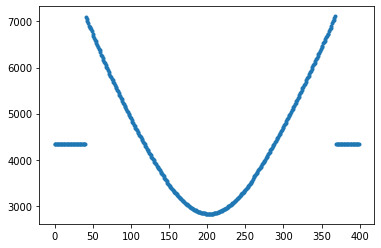

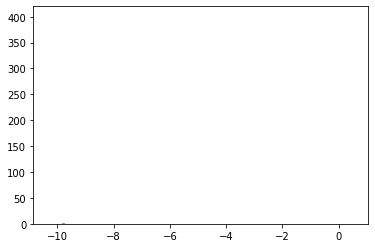

In [214]:

plt.figure()
#plt.hist(dg['sounding']['SIstartRange_samples'],100)
#plt.plot(dg['sounding']['SIstartRange_samples'],'.')
nn = np.diff(dg['sounding']['SIstartRange_samples'])
#plt.plot(nn[np.abs(nn) < 1000],'.')
#plt.plot(dg['sounding']['SIstartRange_samples'],dg['sounding']['detectionMethod'],'.')
ii = np.array(dg['sounding']['detectionMethod']) == 0
tmp = np.array(dg['sounding']['SIstartRange_samples'])
tmp[ii] = np.mean(tmp)
plt.plot(tmp,'.')

plt.figure()
plt.hist(dg['sounding']['postProcessingInfo'],100)

plt.hist(dg['sounding']['reflectivity2_dB'][dg['sounding']['reflectivity1_dB'] == -100])
print(np.flatnonzero(np.array([dg['sounding']['reflectivity1_dB'] == -100])))

[1.23 2.35 2.35]


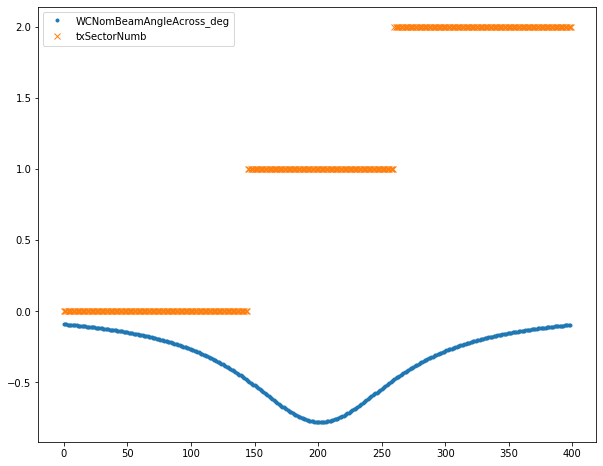

In [149]:
from scipy import stats
print(np.round([1.234,2.345,2.3456],decimals=2))
#print([y for x, y in zip(dg['sounding']['detectionMethod'],dg['sounding']['reflectivity1_dB']) if x != 0 ])
tmp = np.round([y for x, y in zip(dg['sounding']['detectionMethod'],dg['sounding']['reflectivity1_dB']) if x != 0 ],decimals=2)
#print(stats.mode(tmp))
reflectivity1_dB_mode = stats.mode(
    [y for x, y in zip(dg['sounding']['detectionMethod'],dg['sounding']['reflectivity1_dB']) if x != 0 ])[0][0]
#print(reflectivity1_dB_mode)
tmp = dg['sounding']['reflectivity1_dB']
#print([y if x != 0 else reflectivity1_dB_mode for x,y in zip(dg['sounding']['detectionMethod'],dg['sounding']['reflectivity1_dB'])])

#print([[x,y] for x,y in zip(dg['sounding']['detectionMethod'],dg['sounding']['meanAbsCoeff_dbPerkm'])])

#plt.figure()
#plt.hist(dg['sounding']['meanAbsCoeff_dbPerkm'],100)
plt.figure(figsize=(10,8))
plt.plot(np.diff(dg['sounding']['WCNomBeamAngleAcross_deg']),'.')
plt.plot(dg['sounding']['txSectorNumb'],'x')
plt.legend(['WCNomBeamAngleAcross_deg','txSectorNumb'])

#print([y if x == 2 else reflectivity1_dB_mode for x, y in 
#            zip(dg['sounding']['detectionMethod'], dg['sounding']['reflectivity1_dB'])])

#for k in dg['sounding']:
#    print(k)
    
#for x,y in zip(dg['sounding']['detectionMethod'], dg['sounding']['reflectivity1_dB']):    
#    print("%d:%f" % (x,y))




In [205]:
importlib.reload(kmall)
K = kmall.kmall('compressiondata/0007_20190513_154724_ASVBEN.kmall')
T = kmall.kmall('compressiondata/test_woImagery_encodedcompressedsoundings.kmall')
K.index_file()
T.OpenFiletoWrite()

for offset, size, mtype in zip(K.Index['ByteOffset'],K.Index['MessageSize'],K.Index['MessageType']):
    K.FID.seek(offset,0)
    if mtype == "b'#MRZ'":
        dg = K.read_EMdgmMRZ()
        #T.print_datagram(dg['sounding'])
        T.write_EMdgmCZ1_woImageryEncodedAndCompressedSoundings(dg)    
    else:
        buffer = K.FID.read(size)
        T.FID.write(buffer)
    
K.closeFile()
T.index_file()
T.closeFile()

!ls -lh compressiondata/

T.index_file()
T.Index.head()
print(T.Index)



total 577968
-rwxr-xr-x  1 vschmidt  1129769604    32M Feb  6 15:58 0007_20190513_154724_ASVBEN.kmall
-rwxr-xr-x  1 vschmidt  1129769604    20M Feb  8 21:24 0007_20190513_154724_ASVBEN.kmall2.bz2
-rw-r--r--  1 vschmidt  1129769604    32M Feb 11 06:18 test.kmall
-rw-r--r--  1 vschmidt  1129769604    12M Feb 11 06:29 test_encodedcompressedsoundingsandimagery_p1.kmall
-rw-r--r--  1 vschmidt  1129769604    12M Feb  9 21:11 test_encodedcompressedsoundingsandimagery_p4.kmall
-rw-r--r--  1 vschmidt  1129769604    23M Feb  8 20:31 test_woImagery.kmall
-rw-r--r--  1 vschmidt  1129769604    14M Feb 11 08:04 test_woImagery.kmall2.bz2
-rw-r--r--  1 vschmidt  1129769604    15M Feb 11 06:25 test_woImagery_compressedsoundings.kmall
-rw-r--r--  1 vschmidt  1129769604    15M Feb  8 21:29 test_woImagery_compressedsoundings.kmall.bz2
-rw-r--r--  1 vschmidt  1129769604    16M Feb  8 21:32 test_woImagery_compressedsoundings_Native.kmall.bz2
-rw-r--r--@ 1 vschmidt  1129769604   7.6M Feb 22 21:25 test_woImag

In [206]:
print(6629363)
msg_type_groupt = T.Index.groupby("MessageType")
msg_type_groupt["MessageSize"].sum()


6629363


MessageType
b'#CPO'      13572
b'#CZ1'    6628250
b'#IIP'       1054
b'#IOP'       1332
b'#SCL'       6612
b'#SKM'    1159680
b'#SPO'      13572
b'#SVP'        292
b'#SVT'     148308
Name: MessageSize, dtype: int64

We need to now make sure we can decompress and decode not just the individual packets, but the whole file and make sure it produces that something is instantly readable by a commericial package and see what if any effect the small loss of information might have.

In [229]:
importlib.reload(kmall)
T = kmall.kmall(filename='compressiondata/test_woImagery_encodedcompressedsoundings.kmall')
T.index_file()
K2 = kmall.kmall(filename='compressiondata/test_woImagery_encodedcompressedsoundings_DECODED.kmall')
K2.OpenFiletoWrite()

for offset, size, mtype in zip(T.Index['ByteOffset'],T.Index['MessageSize'],T.Index['MessageType']):
    T.FID.seek(offset,0)
    if mtype == "b'#CZ1'":
        dg = T.read_EMdgmCZ1()
        #K2.print_datagram(dg['sounding'])
        #K2.print_datagram(dg)
        K2.write_EMdgmMRZ(dg)    
    else:
        buffer = T.FID.read(size)
        K2.FID.write(buffer)

T.closeFile()
K2.closeFile()
!ls -l compressiondata/
K2.index_file()
print(K2.Index)

total 606152
-rwxr-xr-x  1 vschmidt  1129769604  33900548 Feb  6 15:58 0007_20190513_154724_ASVBEN.kmall
-rwxr-xr-x  1 vschmidt  1129769604  20465434 Feb  8 21:24 0007_20190513_154724_ASVBEN.kmall2.bz2
-rw-r--r--  1 vschmidt  1129769604  33900548 Feb 11 06:18 test.kmall
-rw-r--r--  1 vschmidt  1129769604  12913440 Feb 11 06:29 test_encodedcompressedsoundingsandimagery_p1.kmall
-rw-r--r--  1 vschmidt  1129769604  12913440 Feb  9 21:11 test_encodedcompressedsoundingsandimagery_p4.kmall
-rw-r--r--  1 vschmidt  1129769604  24153350 Feb  8 20:31 test_woImagery.kmall
-rw-r--r--  1 vschmidt  1129769604  14829376 Feb 11 08:04 test_woImagery.kmall2.bz2
-rw-r--r--  1 vschmidt  1129769604  16246210 Feb 11 06:25 test_woImagery_compressedsoundings.kmall
-rw-r--r--  1 vschmidt  1129769604  15629269 Feb  8 21:29 test_woImagery_compressedsoundings.kmall.bz2
-rw-r--r--  1 vschmidt  1129769604  16855092 Feb  8 21:32 test_woImagery_compressedsoundings_Native.kmall.bz2
-rw-r--r--@ 1 vschmidt  1129769604  

In [230]:
msg_type_groupt = K2.Index.groupby("MessageType")
msg_type_groupt["MessageSize"].sum()

MessageType
b'#CPO'       13572
b'#IIP'        1054
b'#IOP'        1332
b'#MRZ'    22808928
b'#SCL'        6612
b'#SKM'     1159680
b'#SPO'       13572
b'#SVP'         292
b'#SVT'      148308
Name: MessageSize, dtype: int64

In [120]:
msg_type_groupt = T.Index.groupby("MessageType")
msg_type_groupt["MessageSize"].sum()

MessageType
b'#CPO'      13572
b'#CR1'    5347345
b'#IIP'       1054
b'#IOP'       1332
b'#SCL'       6612
b'#SKM'    1159680
b'#SPO'      13572
b'#SVP'        292
b'#SVT'     148308
Name: MessageSize, dtype: int64

[]


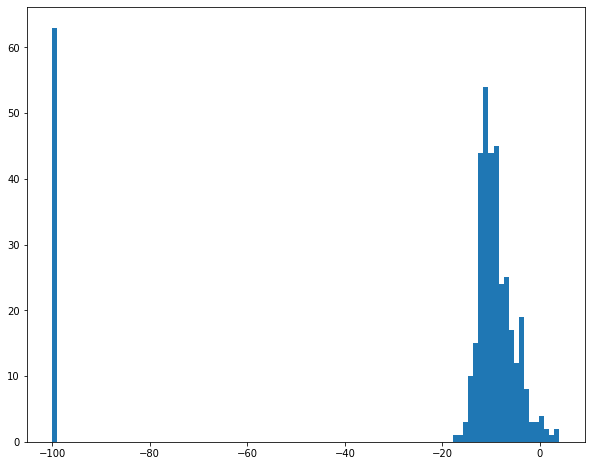

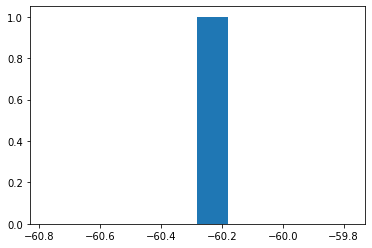

In [222]:

plt.figure(figsize=(10,8))
plt.hist(dg['sounding']['reflectivity1_dB'],100)
plt.figure()
plt.hist(dg['sounding']['reflectivity2_dB'][dg['sounding']['reflectivity1_dB'] == -100])
print(np.flatnonzero(np.array([dg['sounding']['reflectivity1_dB'] == -100])))

(array([  1.,   0.,   2.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,   1.,
          2.,   2.,   4.,   5.,   5.,   2.,   4.,   6.,   7.,   5.,   8.,
         14.,  14.,  18.,  13.,  13.,  10.,  24.,  24.,  28.,  44.,  42.,
         49.,  50.,  52.,  66.,  70.,  59.,  91., 101., 118., 123., 140.,
        132., 158., 225., 220., 232., 231., 301., 289., 345., 361., 371.,
        313., 377., 446., 408., 355., 380., 311., 338., 330., 272., 265.,
        187., 220., 223., 162., 155., 156., 111., 123., 128., 104.,  85.,
         77.,  95.,  78.,  54.,  57.,  56.,  50.,  44.,  49.,  55.,  42.,
         27.,  31.,  31.,  25.,  15.,  10.,  10.,   3.,   7.,   3.,   1.,
          1.]),
 array([-423.  , -417.18, -411.36, -405.54, -399.72, -393.9 , -388.08,
        -382.26, -376.44, -370.62, -364.8 , -358.98, -353.16, -347.34,
        -341.52, -335.7 , -329.88, -324.06, -318.24, -312.42, -306.6 ,
        -300.78, -294.96, -289.14, -283.32, -277.5 , -271.68, -265.86,
        -260.04, -254.22, -248.4 ,

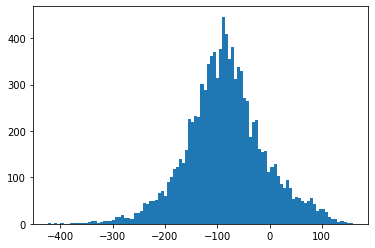

In [4]:
# Looking at imagery data...
importlib.reload(kmall)
K = kmall.kmall('compressiondata/0007_20190513_154724_ASVBEN.kmall')
K.index_file()
#        SKMOffsets = [x for x, y in zip(self.msgoffset, self.msgtype) if y == "b'#SKM'"]


mrz = [x for x, y, z  in zip(K.Index['ByteOffset'],K.Index['MessageSize'],K.Index['MessageType']) if z == "b'#MRZ'"]
K.FID.seek(mrz[0],0)
dg = K.read_EMdgmMRZ()
plt.hist(dg['SIsample_desidB'],100)

In [186]:

# 0-7
dg['sounding']['txSectorNumb']
# 0-2
dg['sounding']['detectionType']
# 0-15
dg['sounding']['detectionMethod']

t = np.array(dg['sounding']['detectionType']) * 100. + 10.* np.array(dg['sounding']['detectionMethod']) + np.array(dg['sounding']['txSectorNumb'])
#print(t)
dT = np.round(t/100.)
dM = np.round((t-dT*100)/10.)
tS = np.round((t-dT*100 - dM*10))
print(dT-np.array(dg['sounding']['detectionType']))
print(dM-np.array(dg['sounding']['detectionMethod']))
print(tS-np.array(dg['sounding']['txSectorNumb']))

print(np.max(t))
print(np.min(t))



SyntaxError: invalid syntax (<ipython-input-186-94230c6f3d5a>, line 8)